The goal for this Python notebook is to do the initial investigation for locating shopping centres in the map, to demonstrate a buffer zone using one shopping centre location, and to find out the appropriate household income datasets to be used in the later stage.

# 1. Get the geographic location of shopping centres

Here we use `Geopy` to find the geographic location of shopping centres.

In [1]:
from descartes import PolygonPatch
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from ipywidgets import interact, fixed, widgets
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 10)

In [3]:
address = 'airport west shopping centre'
geocoder = Nominatim(user_agent='Isochrone calculator')
location = geocoder.geocode(address)
location

Location(Airport West Shopping Centre, Louis Street, Airport West, Melbourne, City of Moonee Valley, Victoria, 3042, Australia, (-37.7134557, 144.8886279, 0.0))

In [4]:
location.latitude, location.longitude

(-37.7134557, 144.8886279)

In [5]:
m = folium.Map((location.latitude, location.longitude), max_zoom=20, zoom_start=16)
folium.Marker((location.latitude, location.longitude), popup=address).add_to(m)
m

In [6]:
home = pd.DataFrame([{'address': address}])
home

,address
0,airport west shopping centre


In [7]:
home = gpd.tools.geocode(home['address'], Nominatim, user_agent='Isochrone calculator')

In [8]:
home

,geometry,address
0,POINT (144.88863 -37.71346),"Airport West Shopping Centre, Louis Street, Ai..."


In [9]:
m = folium.Map((location.latitude, location.longitude), max_zoom=20, zoom_start=16)
folium.GeoJson(home, tooltip=folium.GeoJsonTooltip(['address'])).add_to(m)
m

# 2. Get the buffer of 1km, 5km and 10km

It's definitely worth seeing this on a map - this will be a 5000 metre circle around the Airport West Shopping Centre.

In [10]:
buffer = home.to_crs(epsg=7855).buffer(5000).to_crs(epsg=4326)

In [11]:
m = folium.Map((location.latitude, location.longitude), max_zoom=20, zoom_start=12)
folium.GeoJson(buffer).add_to(m)
folium.GeoJson(home, tooltip=folium.GeoJsonTooltip(['address'])).add_to(m)
m

# 3. Use AURIN API to Get Income Data at sa1 Level

In [13]:
pip install owslib==0.25.0 fiona==1.8.21 geopandas==0.10.2 requests==2.28.0 folium==0.12.1

     |████████████████████████████████| 216 kB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 16.6 MB 12.3 MB/s eta 0:00:01   |█████████████▎                  | 6.9 MB 9.6 MB/s eta 0:00:02
     |████████████████████████████████| 1.0 MB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 1.7 MB/s eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: fiona
    Found existing installation: Fiona 1.8.18
    Uninstalling Fiona-1.8.18:
      Successfully uninstalled Fiona-1.8.18
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.9.0
    Uninstalling geopandas-0.9.0:
      Successfully uninstalled geopandas-0.9.0
  Attempting uninstall: folium
    Found existing installation: folium 0.0.0
    Uninstalling folium-0.0.0:
      S

In [14]:
from owslib.wfs import WebFeatureService

import folium
import io

Please use your AURIN credentials to fill in the `WFS_USERNAME` and `WFS_PASSWORD`. If you don’t have the AURIN credentials, please generate your credentials via [ADP Access Dashboard](https://adp-access.aurin.org.au/login?redirectUri=https%3A%2F%2Fadp-access.aurin.org.au%2F). For more information about the ADP Access Dashboard, please read this [tutorial](https://aurin.org.au/resources/training/adp-access/). 

In [15]:
WFS_USERNAME = '*****'
WFS_PASSWORD= '*************'
WFS_URL='https://adp.aurin.org.au/geoserver/wfs'

In [16]:
adp_client = WebFeatureService(url=WFS_URL,username=WFS_USERNAME, password=WFS_PASSWORD, version='2.0.0')

In [17]:
contents = list(adp_client.contents)
contents[:10]

['datasource-NSW_Govt_DPE-UoM_AURIN_DB:nsw_srlup_additional_rural_2014',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:aus_2016_aust',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:gccsa_2011_aust',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:gccsa_2016_aust',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:mb_2016_aust',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:mb_2011_act',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:mb_2011_nsw',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:mb_2011_nt',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:mb_2011_ot',
 'datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel:mb_2011_qld']

In [31]:
response = adp_client.getfeature(typename='datasource-AU_Govt_ABS_Census-UoM_AURIN_DB_2:sa1_g29_total_hsehold_income_by_hsehold_census_2016',outputFormat='application/json')

In [32]:
# this operation may take 4 to 5 minutes.
out = open('sa1_hshincome.geojson', 'wb')
out.write(response.read())
out.close()
sa1_hshincome = gpd.read_file('sa1_hshincome.geojson')

In [33]:
sa1_hshincome.head()

,id,sa1_main16,sa1_7dig16,neg_nil_inc_fam_households,neg_nil_inc_non_fam_househlds,negative_nil_income_tot,hi_1_149_family_households,hi_1_149_non_family_hseholds,hi_1_149_tot,hi_150_299_family_households,...,part_inc_stated_fam_household,part_inc_std_non_fam_hhds,partial_income_stated_tot,all_incomes_ns_famly_househld,all_inc_ns_non_famly_househld,all_incomes_not_stated_tot,tot_family_households,tot_non_family_households,tot_tot,geometry
0,sa1_g29_total_hsehold_income_by_hsehold_census...,10102100819,1100819,0,0,0,0,0,0,0,...,6,0,11,0,0,0,130,18,147,"MULTIPOLYGON (((149.22820 -35.37816, 149.22825..."
1,sa1_g29_total_hsehold_income_by_hsehold_census...,10102101123,1101123,0,0,0,0,0,0,0,...,3,0,3,3,0,3,54,4,59,"MULTIPOLYGON (((149.15855 -35.50807, 149.15954..."
2,sa1_g29_total_hsehold_income_by_hsehold_census...,10103101401,1101401,0,0,0,0,0,0,0,...,3,0,3,0,0,3,52,33,84,"MULTIPOLYGON (((149.12954 -36.21800, 149.12965..."
3,sa1_g29_total_hsehold_income_by_hsehold_census...,10104101909,1101909,0,0,0,0,0,0,0,...,6,0,6,5,8,9,71,66,136,"MULTIPOLYGON (((149.83118 -36.67558, 149.83134..."
4,sa1_g29_total_hsehold_income_by_hsehold_census...,10104102006,1102006,0,0,0,0,3,3,4,...,4,0,8,3,0,3,86,57,141,"MULTIPOLYGON (((149.61131 -36.98110, 149.61238..."


In [34]:
sa1_hshincome.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 57490 entries, 0 to 57489
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   id                             57490 non-null  object  
 1   sa1_main16                     57490 non-null  object  
 2   sa1_7dig16                     57490 non-null  object  
 3   neg_nil_inc_fam_households     57490 non-null  int64   
 4   neg_nil_inc_non_fam_househlds  57490 non-null  int64   
 5   negative_nil_income_tot        57490 non-null  int64   
 6   hi_1_149_family_households     57490 non-null  int64   
 7   hi_1_149_non_family_hseholds   57490 non-null  int64   
 8   hi_1_149_tot                   57490 non-null  int64   
 9   hi_150_299_family_households   57490 non-null  int64   
 10  hi_150_299_non_fam_househlds   57490 non-null  int64   
 11  hi_150_299_tot                 57490 non-null  int64   
 12  hi_300_399_family_househ

## 3.2 Choose a different dataset: SA1-G02 Selected Medians and Averages-Census 2016

The 'sa1_hshincome.geojson' dataset doesn't have a direct median income variable. Therefore, we searched the AURIN data catalogue again to find an income dataset that contains the processed median income information. 

The new dataset we found is called "SA1-G02 Selected Medians and Averages-Census 2016". 
This dataset has direct median income information at the SA1 level. Other convenient variables include:<br>
Average household size, Average number of persons per bedroom, Geometry Field, Median age of persons, Median mortgage repayment monthly, Median rent weekly, Median total family income weekly, Median total household income weekly, Median total personal income weekly<br>
https://data.aurin.org.au/dataset/au-govt-abs-census-sa1-g02-selected-medians-and-averages-census-2016-sa1-2016<br>
The income data is generated from **View the data quality statement for Household income, total weekly (HIND)**<br> for a more detailed family weekly income distribution, this is the best source of information. The HIND doesn't include median, 25%, 75% income information, which I assume can be calculated based on the HIND. <br>
https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/2900.0main+features101222016


In [35]:
response = adp_client.getfeature(typename='datasource-AU_Govt_ABS_Census-UoM_AURIN_DB_2:sa1_g02_selected_medians_and_averages_census_2016',outputFormat='application/json')

In [36]:
# this operation may take 4 to 5 minutes.
out = open('sa1_med_income.geojson', 'wb')
out.write(response.read())
out.close()
sa1_med_income = gpd.read_file('sa1_med_income.geojson')

In [37]:
sa1_med_income.head()

,id,sa1_main16,sa1_7dig16,median_age_persons,median_mortgage_repay_monthly,median_tot_prsnl_inc_weekly,median_rent_weekly,median_tot_fam_inc_weekly,average_num_psns_per_bedroom,median_tot_hhd_inc_weekly,average_household_size,geometry
0,sa1_g02_selected_medians_and_averages_census_2...,50701125905,5125905,29,1935,862,400,2083,0.7,2070,2.9,"MULTIPOLYGON (((115.82094 -32.13599, 115.82094..."
1,sa1_g02_selected_medians_and_averages_census_2...,10106154228,1154228,40,2290,980,250,2339,0.8,1989,2.7,"MULTIPOLYGON (((148.89686 -34.87468, 148.89754..."
2,sa1_g02_selected_medians_and_averages_census_2...,50701125911,5125911,33,2612,1077,486,2760,0.8,2591,3.2,"MULTIPOLYGON (((115.81278 -32.13580, 115.81297..."
3,sa1_g02_selected_medians_and_averages_census_2...,50702116519,5116519,40,1733,831,300,2036,0.8,1231,1.8,"MULTIPOLYGON (((115.77499 -32.04945, 115.77497..."
4,sa1_g02_selected_medians_and_averages_census_2...,11201124210,1124210,73,0,0,0,0,0.0,0,2.0,"MULTIPOLYGON (((153.59891 -28.80611, 153.59893..."


In [38]:
sa1_med_income.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 57490 entries, 0 to 57489
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   id                             57490 non-null  object  
 1   sa1_main16                     57490 non-null  object  
 2   sa1_7dig16                     57490 non-null  object  
 3   median_age_persons             57490 non-null  int64   
 4   median_mortgage_repay_monthly  57490 non-null  int64   
 5   median_tot_prsnl_inc_weekly    57490 non-null  int64   
 6   median_rent_weekly             57490 non-null  int64   
 7   median_tot_fam_inc_weekly      57490 non-null  int64   
 8   average_num_psns_per_bedroom   57490 non-null  float64 
 9   median_tot_hhd_inc_weekly      57490 non-null  int64   
 10  average_household_size         57490 non-null  float64 
 11  geometry                       57490 non-null  geometry
dtypes: float64(2), geometry(

> There are 57,523 spatial SA1 regions covering the whole of Australia without gaps or overlaps. These include 33 non-spatial SA1 special purpose codes, comprising Migratory–Offshore–Shipping and No Usual Address codes for each State and Territory.

Based on the ABS description of SA1, there are 57,523 spatial SA1 regions. There are 57,490 SA1 regions in our dataset, therefore, we assume this dataset covers all SA1 regions in Australia.
https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/1270.0.55.001~July%202016~Main%20Features~Statistical%20Area%20Level%201%20(SA1)~10013#:~:text=There%20are%2057%2C523%20spatial%20SA1,for%20each%20State%20and%20Territory.

Since the population size varies for different SA1, in order to consider the population weights for SA1s that can influence the purchasing power of an area, we need to join `tot_tot`: the total number of family households and non family households from 'sa1_hshincome.geojson' to 'sa1_med_income.geojson', using `join` function.

In [47]:
sa1_med_income.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Islands, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

I was confusing geopandas.sjoin with geopandas.GeoDataFrame.sjoin.
https://stackoverflow.com/questions/70393202/why-is-my-geopandas-installation-missing-sjoin-attributeerror-geodataframe-o

In [49]:
gdf_med = geopandas.GeoDataFrame(sa1_med_income, crs="EPSG:4283")
gdf_med

,id,sa1_main16,median_age_persons,median_mortgage_repay_monthly,median_tot_prsnl_inc_weekly,median_rent_weekly,median_tot_fam_inc_weekly,average_num_psns_per_bedroom,median_tot_hhd_inc_weekly,average_household_size,geometry
sa1_7dig16,,,,,,,,,,,
5125905,sa1_g02_selected_medians_and_averages_census_2...,50701125905,29,1935,862,400,2083,0.7,2070,2.9,"MULTIPOLYGON (((115.82094 -32.13599, 115.82094..."
1154228,sa1_g02_selected_medians_and_averages_census_2...,10106154228,40,2290,980,250,2339,0.8,1989,2.7,"MULTIPOLYGON (((148.89686 -34.87468, 148.89754..."
5125911,sa1_g02_selected_medians_and_averages_census_2...,50701125911,33,2612,1077,486,2760,0.8,2591,3.2,"MULTIPOLYGON (((115.81278 -32.13580, 115.81297..."
5116519,sa1_g02_selected_medians_and_averages_census_2...,50702116519,40,1733,831,300,2036,0.8,1231,1.8,"MULTIPOLYGON (((115.77499 -32.04945, 115.77497..."
1124210,sa1_g02_selected_medians_and_averages_census_2...,11201124210,73,0,0,0,0,0.0,0,2.0,"MULTIPOLYGON (((153.59891 -28.80611, 153.59893..."
...,...,...,...,...,...,...,...,...,...,...,...
5116123,sa1_g02_selected_medians_and_averages_census_2...,50701116123,29,2500,1065,478,2422,0.8,2374,3.2,"MULTIPOLYGON (((115.84976 -32.16663, 115.84987..."
5116407,sa1_g02_selected_medians_and_averages_census_2...,50702116407,47,2184,858,495,2535,0.8,1697,2.5,"MULTIPOLYGON (((115.75808 -32.04396, 115.75806..."
5116309,sa1_g02_selected_medians_and_averages_census_2...,50701116309,37,1733,815,380,2026,0.7,1696,2.7,"MULTIPOLYGON (((115.82048 -32.11480, 115.82111..."


# 4. Select sa1 Income Data inside the Buffer

In [52]:
sa1_med_income.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Islands, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [53]:
buffer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
pp = buffer.geometry.to_crs('EPSG:4283')

In [55]:
test = sa1_med_income.intersects(pp.iloc[0])

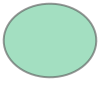

In [56]:
pp.iloc[0]

In [57]:
test[test]

sa1_7dig16
2123104    True
2143850    True
2123920    True
2111412    True
2111405    True
           ... 
2125019    True
2124537    True
2125002    True
2125012    True
2125013    True
Length: 363, dtype: bool

In [58]:
b = test[test]

In [60]:
frames = [sa1_med_income, test]

In [61]:
result = pd.concat(frames)

In [62]:
b.index

Index(['2123104', '2143850', '2123920', '2111412', '2111405', '2111407',
       '2111409', '2111411', '2111424', '2111426',
       ...
       '2124517', '2124518', '2124526', '2124533', '2124535', '2125019',
       '2124537', '2125002', '2125012', '2125013'],
      dtype='object', name='sa1_7dig16', length=363)

In [63]:
west_airport = sa1_med_income.loc[b.index]
west_airport

,id,sa1_main16,median_age_persons,median_mortgage_repay_monthly,median_tot_prsnl_inc_weekly,median_rent_weekly,median_tot_fam_inc_weekly,average_num_psns_per_bedroom,median_tot_hhd_inc_weekly,average_household_size,geometry
sa1_7dig16,,,,,,,,,,,
2123104,sa1_g02_selected_medians_and_averages_census_2...,21001123104,42,1975,872,370,2374,0.9,2021,2.8,"MULTIPOLYGON (((144.90635 -37.73834, 144.90587..."
2143850,sa1_g02_selected_medians_and_averages_census_2...,21003143850,37,2000,401,331,983,0.9,905,2.8,"MULTIPOLYGON (((144.93766 -37.69717, 144.93779..."
2123920,sa1_g02_selected_medians_and_averages_census_2...,21003123920,40,1733,683,388,2042,0.8,1765,2.9,"MULTIPOLYGON (((144.93679 -37.72435, 144.93686..."
2111412,sa1_g02_selected_medians_and_averages_census_2...,20603111412,35,2167,1047,358,2931,0.9,2476,2.9,"MULTIPOLYGON (((144.89179 -37.75419, 144.89293..."
2111405,sa1_g02_selected_medians_and_averages_census_2...,20603111405,41,2167,756,420,2232,0.8,1514,2.4,"MULTIPOLYGON (((144.89754 -37.74127, 144.89756..."
...,...,...,...,...,...,...,...,...,...,...,...
2125019,sa1_g02_selected_medians_and_averages_census_2...,21005125019,0,0,0,0,0,0.0,0,0.0,"MULTIPOLYGON (((144.88358 -37.70416, 144.88327..."
2124537,sa1_g02_selected_medians_and_averages_census_2...,21005124537,0,0,0,0,0,0.0,0,0.0,"MULTIPOLYGON (((144.90974 -37.67443, 144.90991..."
2125002,sa1_g02_selected_medians_and_averages_census_2...,21005125002,39,1733,531,330,1375,0.8,1224,2.7,"MULTIPOLYGON (((144.87381 -37.70038, 144.87429..."


<AxesSubplot:>

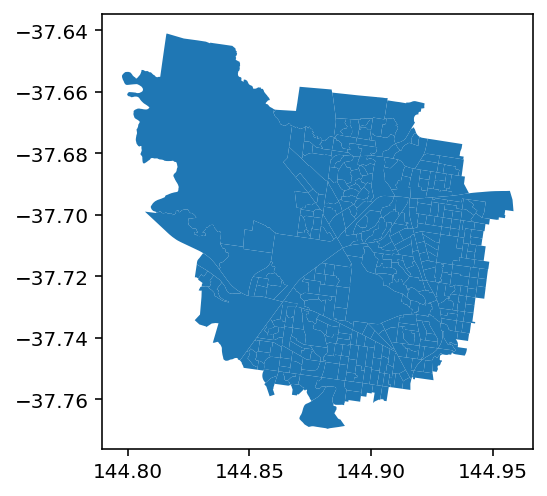

In [64]:
west_airport.plot()

In [68]:
w = west_airport.describe()
w

,median_age_persons,median_mortgage_repay_monthly,median_tot_prsnl_inc_weekly,median_rent_weekly,median_tot_fam_inc_weekly,average_num_psns_per_bedroom,median_tot_hhd_inc_weekly,average_household_size
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,38.085399,1780.622590,643.308540,327.151515,1720.980716,0.818733,1452.539945,2.514325
std,8.204963,523.580705,203.633754,91.845755,614.356936,0.202011,513.743541,0.596781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,1615.000000,517.000000,320.000000,1391.000000,0.800000,1210.500000,2.400000
50%,39.000000,1820.000000,652.000000,343.000000,1708.000000,0.800000,1437.000000,2.600000
75%,42.000000,2000.000000,770.500000,364.000000,2128.000000,0.900000,1774.000000,2.800000
max,76.000000,3359.000000,1343.000000,572.000000,3531.000000,1.300000,2874.000000,3.300000


In [69]:
w['median_tot_fam_inc_weekly']

count     363.000000
mean     1720.980716
std       614.356936
min         0.000000
25%      1391.000000
50%      1708.000000
75%      2128.000000
max      3531.000000
Name: median_tot_fam_inc_weekly, dtype: float64

In [70]:
w['median_tot_fam_inc_weekly'].T

count     363.000000
mean     1720.980716
std       614.356936
min         0.000000
25%      1391.000000
50%      1708.000000
75%      2128.000000
max      3531.000000
Name: median_tot_fam_inc_weekly, dtype: float64